### 1D Autoregressive Token prediction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random
import contextlib
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import acf, pacf

#### Data Preparation

##### Geometric Brownian Motion Simulator

$S_t = S_0 \exp\left(\left(\mu - \frac{\sigma^2}{2}\right) t + \sigma W_t\right)$


$dS_t = \mu S_tdt + \sigma S_tdW_t \\$

$S_0$: Initial Stock price $\\$
$\mu$: Drift coefficient $\\$
$\sigma$: Volatility coefficient $\\$
$W_t$: Wiener Process (Brownian motion)



In [2]:
def gbm_simulator(key, S0, mu, sigma, T, dt):
    # Number of time steps
    N = int(T / dt)
    t = jnp.linspace(0, T, N)
    W = random.normal(key, (N,)) * jnp.sqrt(dt)
    
    # Wiener process
    W = jnp.cumsum(W)
    S = S0 * jnp.exp((mu - 0.5 * sigma**2) * t + sigma * W)
    return S

# Parameters for the GBM
S0 = 100.0                  # Initial stock price
mu = 0.1                    # Drift coefficient
sigma = 0.2                 # Volatility coefficient
T = 5.0                     # Total time (year)
dt = 0.005                  # Time step

# Generate random key
key = random.PRNGKey(0)

# Simulate GBM
GBM_data = gbm_simulator(key, S0, mu, sigma, T, dt)

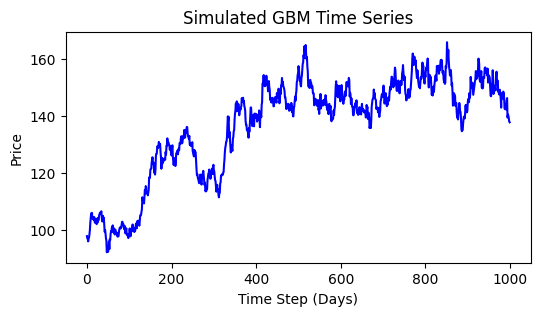

Mean Price: 136.36
Standard Deviation of Price: 17.87


In [3]:
# Plot the time series
plt.figure(figsize=(6, 3))
plt.plot(GBM_data, color ='blue')
plt.title('Simulated GBM Time Series')
plt.xlabel('Time Step (Days)')
plt.ylabel('Price')
plt.show()

# Calculate and print basic statistics
mean_price = jnp.mean(GBM_data)
std_dev_price = jnp.std(GBM_data)
print(f"Mean Price: {mean_price:.2f}")
print(f"Standard Deviation of Price: {std_dev_price:.2f}")

Discretizng data

In [4]:
data = np.array(GBM_data)
bin_start = 30
bin_stop = 180
num_bins = 30
bin_edges = np.linspace(bin_start, bin_stop, num_bins + 1)
# Tokenize the data
tokenized_data = np.digitize(GBM_data, bins=bin_edges, right=False) - 1
# Clip any prices below 30 to the first bin and above 170 to the last bin (Token 0 to 29)
tokenized_data = np.clip(tokenized_data, 0, num_bins - 1)
# Train / Test Split
train_data_temp, temp_data = train_test_split(tokenized_data, train_size=0.6, shuffle=False)
val_data_temp, test_data_temp = train_test_split(temp_data, test_size=0.5, shuffle=False)

def prep_data(seq_len, start_indexes, data):
    final_list = []
    for i in start_indexes:
        final_list.append(data[i:i+seq_len])
    return final_list

In [5]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        # Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM Layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        # Fully Connected Layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, hidden=None):
        # A sequence of 50 tokens is passed to the embedding layer and we get the embeddings for each token (dimension: 32)
        embedded = self.embedding(x)                            # Shape: [batch_size, sequence_length, embedding_dim] [1, 50, 32]
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(embedded, hidden)      # Input: 50 tokens, Output: 50 hidden states with dimension 128
        # Apply fully connected layer to each time step
        logits = self.fc(lstm_out)                              # Shape: [batch_size, sequence_length, output_dim]
        
        return logits, hidden                                   # Return predictions for each time step

In [6]:
seq_len = 50
val_data = []
for i in range(len(val_data_temp) // seq_len):
    start_idx = i * seq_len
    end_idx = start_idx + seq_len
    val_data.append(val_data_temp[start_idx:end_idx])

In [7]:
seq_len = 50
val_n_seq = 100
start_val_idx = np.random.choice(range(len(val_data_temp)-seq_len), size=val_n_seq, replace=True)
val_data = prep_data(seq_len=seq_len, start_indexes=start_val_idx, data=val_data_temp)

Loss function and training

In [8]:
model = LSTMModel(vocab_size=num_bins, embedding_dim=32, hidden_dim=64, output_dim=num_bins)

# Loss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training

train_n_seq = 10
num_epochs = 300
train_losses = []
validation_losses = []

best_val_loss = float('inf')

for epoch in range(num_epochs):
    
    start_train_idx = np.random.choice(range(len(train_data_temp)-seq_len), size=train_n_seq, replace=True)
    train_data = prep_data(seq_len=seq_len, start_indexes=start_train_idx, data=train_data_temp)
    
    ## TRAINING
    model.train()
    train_loss = 0
    for sequence in train_data:
        
        optimizer.zero_grad()

        sequence_input = torch.tensor(sequence[:-1]).unsqueeze(0)   # Exclude last token
        targets = torch.tensor(sequence[1:]).unsqueeze(0)           # Exclude first token

        # Shape: [1, sequence_length-1, unique_tokens]
        logits, _ = model(sequence_input)                              # [Token 1, Token 2, ..., Token 49]
        # Reshape logits to combine batch and sequence dimensions
        logits = logits.view(-1, logits.size(-1))                   # Shape: [1*49, 30] -> [49, 30]
        targets = targets.view(-1)                                  # Flatten targets to shape [49]
        # Average loss across all 49 tokens
        loss = criterion(logits, targets)
        train_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss/len(train_data)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch} - Avg Loss per sequence: {avg_train_loss:.4f}")

    ## VALIDATION
    model.eval()
    validation_loss = 0

    # No weight updates
    with torch.no_grad():
        for sequence in val_data:
            sequence_input = torch.tensor(sequence[:-1]).unsqueeze(0)   # Exclude last token
            targets = torch.tensor(sequence[1:]).unsqueeze(0)           # Exclude first token

            logits, _ = model(sequence_input)  # Forward pass
            logits = logits.view(-1, logits.size(-1))  # Shape: [49, 30]
            targets = targets.view(-1)  # Shape: [49]                        
            loss = criterion(logits, targets)
            validation_loss += loss.item()
    
    avg_val_loss = validation_loss / len(val_data)
    validation_losses.append(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    print(f"Epoch {epoch}, Validation Loss: {avg_val_loss:.4f}")

# Save model weights after training/validation
torch.save(model.state_dict(), 'model_weights.pth')

Epoch 0 - Avg Loss per sequence: 3.3424
Epoch 0, Validation Loss: 3.2891
Epoch 1 - Avg Loss per sequence: 3.1958
Epoch 1, Validation Loss: 3.1325
Epoch 2 - Avg Loss per sequence: 3.0356
Epoch 2, Validation Loss: 2.8817
Epoch 3 - Avg Loss per sequence: 2.8510
Epoch 3, Validation Loss: 2.5993
Epoch 4 - Avg Loss per sequence: 2.5362
Epoch 4, Validation Loss: 2.2281
Epoch 5 - Avg Loss per sequence: 2.3085
Epoch 5, Validation Loss: 1.8059
Epoch 6 - Avg Loss per sequence: 1.8452
Epoch 6, Validation Loss: 1.4881
Epoch 7 - Avg Loss per sequence: 1.7968
Epoch 7, Validation Loss: 1.3486
Epoch 8 - Avg Loss per sequence: 1.4848
Epoch 8, Validation Loss: 1.2890
Epoch 9 - Avg Loss per sequence: 1.2964
Epoch 9, Validation Loss: 1.2412
Epoch 10 - Avg Loss per sequence: 1.4189
Epoch 10, Validation Loss: 1.2335
Epoch 11 - Avg Loss per sequence: 1.1972
Epoch 11, Validation Loss: 1.1861
Epoch 12 - Avg Loss per sequence: 1.1545
Epoch 12, Validation Loss: 1.1409
Epoch 13 - Avg Loss per sequence: 1.1010
Epoc

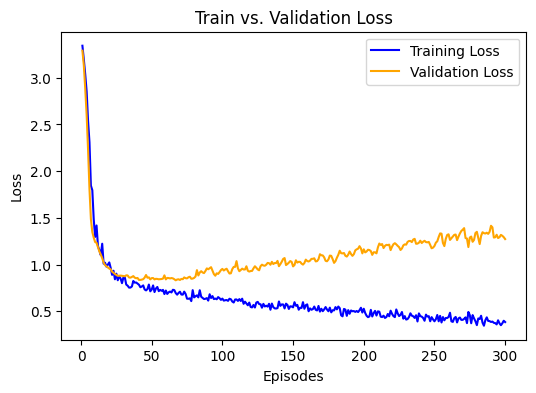

In [9]:
plt.figure(figsize=(6,4))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, len(validation_losses)+1), validation_losses, label = 'Validation Loss', color='orange')
plt.title('Train vs. Validation Loss')
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.legend()
plt.show()

EVALUATION AND TESTING

Validation Data

In [10]:
eval_model = LSTMModel(vocab_size=num_bins, embedding_dim=32, hidden_dim=64, output_dim=num_bins)
eval_model.load_state_dict(torch.load('best_model.pth', weights_only=False))

## VALIDATION
model.eval()
val_loss = []
val_perplexity = []

# No weight updates
with torch.no_grad():
    
    for sequence in val_data:
        
        sequence_input = torch.tensor(sequence[:-1]).unsqueeze(0)   # Exclude last token
        targets = torch.tensor(sequence[1:]).unsqueeze(0)           # Exclude first token
        logits, _ = eval_model(sequence_input)  # Forward pass
        logits = logits.view(-1, logits.size(-1))  # Shape: [49, 30]
        targets = targets.view(-1)  # Shape: [49] 
        
        # Cross entropy Loss
        loss = criterion(logits, targets)
        val_loss.append(loss.item())

        # Log probabilities
        log_probs = F.log_softmax(logits, dim=-1)
        target_log_probs = log_probs[range(len(targets)), targets]

        # Perplexity: exp(-average log probability)
        avg_log_prob = target_log_probs.mean()
        perplexity = torch.exp(-avg_log_prob).item()
        val_perplexity.append(perplexity)

Test Data with Teacher forcing

In [11]:
start_test_idx = np.random.choice(range(len(test_data_temp)-seq_len), size=100, replace=True)
test_data = prep_data(seq_len=seq_len, start_indexes=start_test_idx, data=test_data_temp)

In [12]:
test_model = LSTMModel(vocab_size=num_bins, embedding_dim=32, hidden_dim=64, output_dim=num_bins)
test_model.load_state_dict(torch.load('best_model.pth', weights_only=False))

## TEST DATA
model.eval()
test_loss = []
test_perplexity = []

# No weight updates
with torch.no_grad():
    
    for sequence in test_data:
        
        sequence_input = torch.tensor(sequence[:-1]).unsqueeze(0)   # Exclude last token
        targets = torch.tensor(sequence[1:]).unsqueeze(0)           # Exclude first token
        logits, _ = test_model(sequence_input)  # Forward pass
        logits = logits.view(-1, logits.size(-1))  # Shape: [49, 30]
        targets = targets.view(-1)  # Shape: [49] 
        
        # Cross entropy Loss
        loss = criterion(logits, targets)
        test_loss.append(loss.item())

        # Log probabilities
        log_probs = F.log_softmax(logits, dim=-1)
        target_log_probs = log_probs[range(len(targets)), targets]

        # Perplexity: exp(-average log probability)
        avg_log_prob = target_log_probs.mean()
        perplexity = torch.exp(-avg_log_prob).item()
        test_perplexity.append(perplexity)

#### Perplexity Score

$\text{PP}_N(x) = \frac{1}{\left(\prod_{i=1}^{N} P(x_i \mid w_1 \cdots x_{i-1})\right)^{\frac{1}{N}}} = \left(\prod_{i=1}^{N} P(x_i \mid x_1 \cdots x_{i-1})\right)^{-\frac{1}{N}} = e^{-\frac{1}{N} \sum_{i=1}^{N} \log P(x_i \mid x_{1:i-1})} $


$\text{PP}_N(x) = \exp\left(-\frac{1}{N} \sum_{i=1}^{N} \log P(x_i \mid x_{1:i-1})\right)$



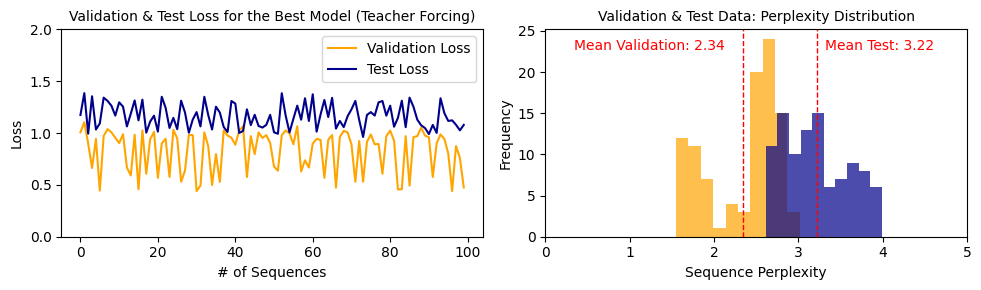

In [13]:
val_perplexity = np.array(val_perplexity)
test_perplexity = np.array(test_perplexity)

mean_test = np.mean(test_perplexity)
mean_val = np.mean(val_perplexity)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

# Plot 1: Validation & Test Loss
axs[0].plot(val_loss, label='Validation Loss', color='orange')
axs[0].plot(test_loss, label='Test Loss', color='darkblue')
axs[0].legend()
axs[0].set_title('Validation & Test Loss for the Best Model (Teacher Forcing)', size=10)
axs[0].set_xlabel('# of Sequences')
axs[0].set_ylabel('Loss')
axs[0].set_ylim(0, 2)

# Plot 2: Histogram of Perplexity Distribution
axs[1].hist(val_perplexity, color='orange', bins=10, alpha=0.7, label='Validation Perplexity')
axs[1].hist(test_perplexity, color='darkblue', bins=10, alpha=0.7, label='Test Perplexity')
axs[1].set_title('Validation & Test Data: Perplexity Distribution', size=10)
axs[1].set_xlabel('Sequence Perplexity')
axs[1].set_ylabel('Frequency')
axs[1].set_xlim(0, 5)

# Vertical lines for the mean values on the histogram
axs[1].axvline(mean_val, color='red', linewidth=1, linestyle='dashed')
axs[1].axvline(mean_test, color='red', linewidth=1, linestyle='dashed')
axs[1].text(mean_val-2.0, axs[1].get_ylim()[1] * 0.9, f'Mean Validation: {mean_val:.2f}', color='red')
axs[1].text(mean_test+0.1, axs[1].get_ylim()[1] * 0.9, f'Mean Test: {mean_test:.2f}', color='red')

plt.tight_layout()
plt.show()


Inference on Test data

In [14]:
## TESTING
test_losses = []
trajectories = []

for sequence in test_data:
    init_real_token = sequence[0]
    sim_trajectory = [init_real_token]
    model.eval()
    # Initialize hidden and cell states to zero
    ## PLEASE ADJUST WHEN HAVING MULTIPLE LSTM LAYERS
    h_n = torch.zeros(1, 1, 64)
    c_n = torch.zeros(1, 1, 64)
    ##
    with torch.no_grad():
        token_loss = 0
        for i in range(1, len(sequence)):
            # Last value in the trajectory
            sequence_input = torch.tensor([sim_trajectory[-1]]).unsqueeze(0)
            
            # Get the model's prediction and pass the hidden and cell states
            logits, (h_n, c_n) = model(sequence_input, (h_n, c_n))
            
            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)
            probs = probs.squeeze()
            predicted_token = torch.multinomial(probs, num_samples=1).item()
            sim_trajectory.append(predicted_token)
            
            # Loss calculation
            true_token = torch.tensor([sequence[i]]).unsqueeze(0)
            true_token = true_token.view(-1)  
            logits = logits.view(-1, logits.size(-1))                                             
            loss = criterion(logits, true_token)
            token_loss += loss.item()
            
    test_losses.append(token_loss/len(sequence))
    trajectories.append(sim_trajectory)

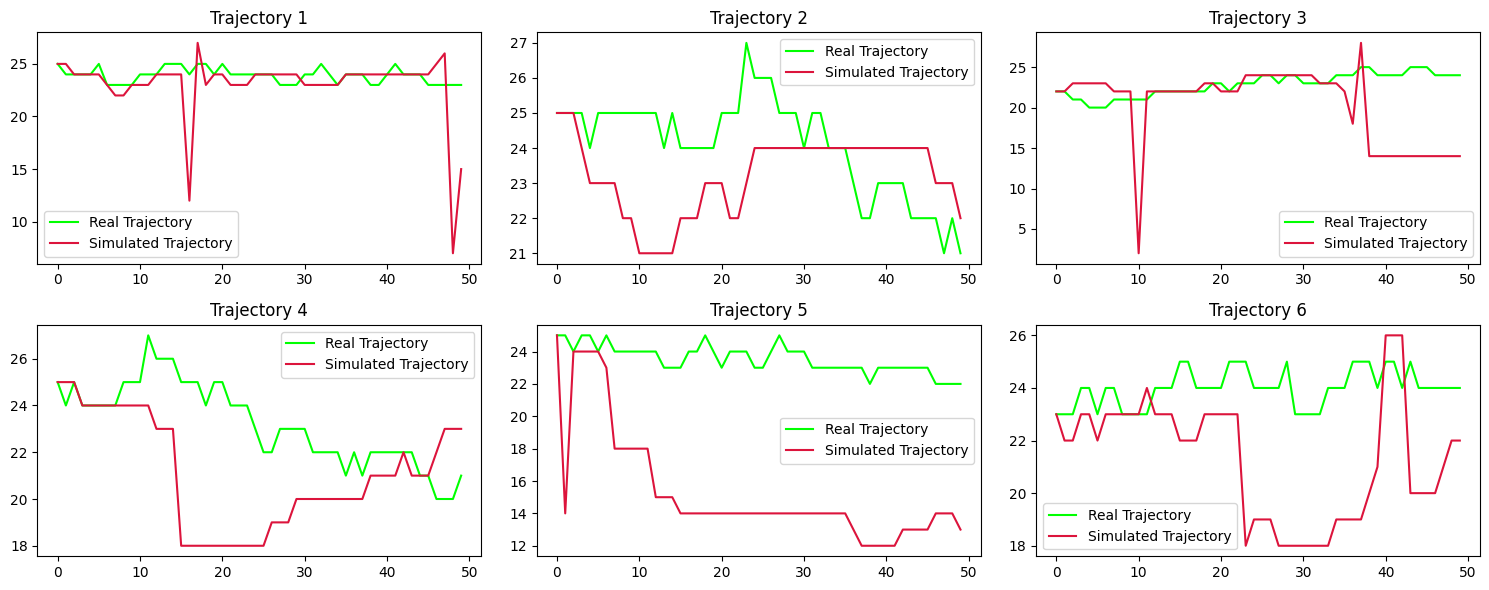

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(15, 6))  # 2 rows, 3 columns, and adjust the size
axes = axes.flatten()
for i in range(6):
    axes[i].plot(test_data[i], label='Real Trajectory', color = 'lime')
    axes[i].plot(trajectories[i], label='Simulated Trajectory', color = 'crimson')
    axes[i].legend()
    axes[i].set_title(f'Trajectory {i+1}')
plt.tight_layout()
plt.show()

Testing with ARGMAX instead of Sampling

In [16]:
## TESTING
test_losses = []
trajectories = []

for sequence in test_data:
    init_real_token = sequence[0]
    sim_trajectory = [init_real_token]
    model.eval()
    # Initialize hidden and cell states to zero
    ## PLEASE ADJUST WHEN HAVING MULTIPLE LSTM LAYERS
    h_n = torch.zeros(1, 1, 64)
    c_n = torch.zeros(1, 1, 64)
    ##
    with torch.no_grad():
        token_loss = 0
        for i in range(1, len(sequence)):
            # Last value in the trajectory
            sequence_input = torch.tensor([sim_trajectory[-1]]).unsqueeze(0)
            
            # Get the model's prediction and pass the hidden and cell states
            logits, (h_n, c_n) = model(sequence_input, (h_n, c_n))
            
            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)
            probs = probs.squeeze()
            predicted_token = torch.argmax(probs).item()
            sim_trajectory.append(predicted_token)
            
            # Loss calculation
            true_token = torch.tensor([sequence[i]]).unsqueeze(0)
            true_token = true_token.view(-1)  
            logits = logits.view(-1, logits.size(-1))                                             
            loss = criterion(logits, true_token)
            token_loss += loss.item()
            
    test_losses.append(token_loss/len(sequence))
    trajectories.append(sim_trajectory)

#### WHEN ARGMAX IS USED

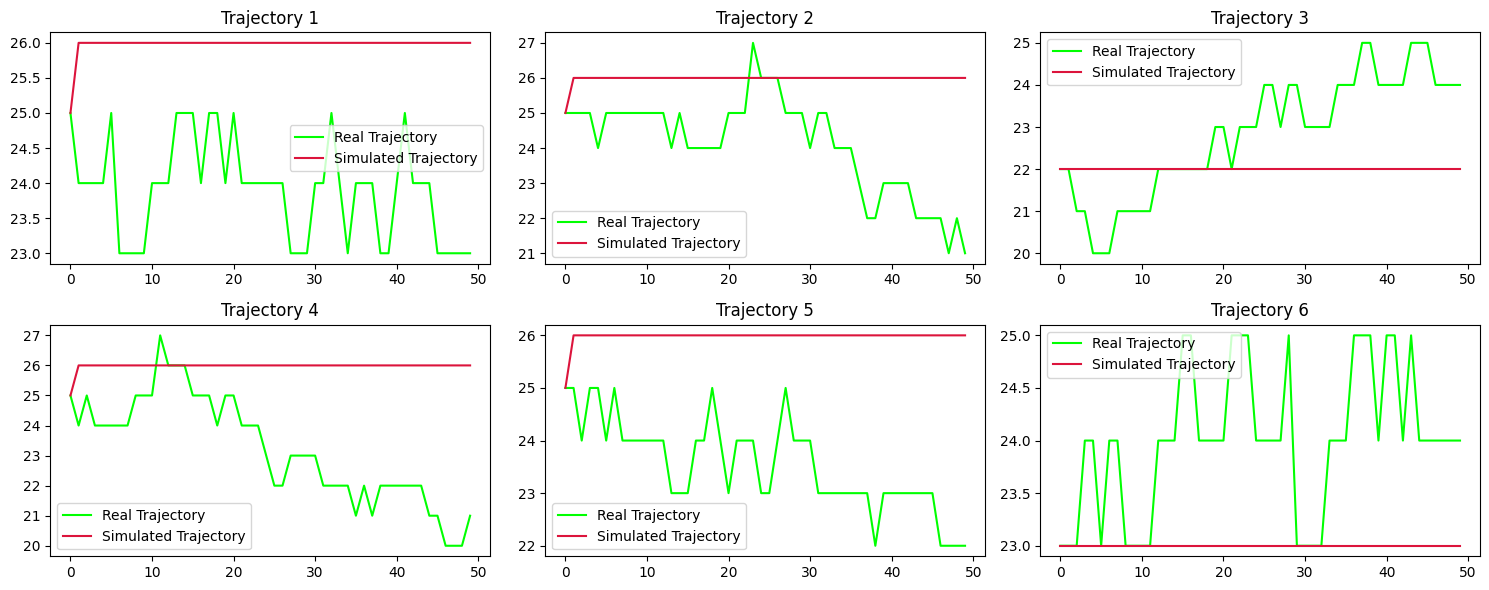

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(15, 6))  # 2 rows, 3 columns, and adjust the size
axes = axes.flatten()
for i in range(6):
    axes[i].plot(test_data[i], label='Real Trajectory', color = 'lime')
    axes[i].plot(trajectories[i], label='Simulated Trajectory', color = 'crimson')
    axes[i].legend()
    axes[i].set_title(f'Trajectory {i+1}')
plt.tight_layout()
plt.show()

Summary Statistics

In [18]:
test_fake_data=np.array(trajectories)

def calculate_statistics(trajectories):
    means = []
    variances = []
    std_devs = []
    skewness = []
    kurtos = []
    max_vals = []
    min_vals = []

    for traj in trajectories:
        means.append(np.mean(traj))
        variances.append(np.var(traj))
        std_devs.append(np.std(traj))
        skewness.append(skew(traj))
        kurtos.append(kurtosis(traj))
        max_vals.append(np.max(traj))
        min_vals.append(np.min(traj))
    
    return means, variances, std_devs, skewness, kurtos, max_vals, min_vals

# Statistics for real and simulated trajectories
real_means, real_variances, real_std_devs, real_skew, real_kurtosis, real_max_vals, real_min_vals = calculate_statistics(test_data)
sim_means, sim_variances, sim_std_devs, sim_skew, sim_kurtosis, sim_max_vals, sim_min_vals = calculate_statistics(test_fake_data)

/var/folders/1x/hjv8bl714_xgsbdy8fp5kj140000gn/T/ipykernel_58496/3210346931.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness.append(skew(traj))
/var/folders/1x/hjv8bl714_xgsbdy8fp5kj140000gn/T/ipykernel_58496/3210346931.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtos.append(kurtosis(traj))


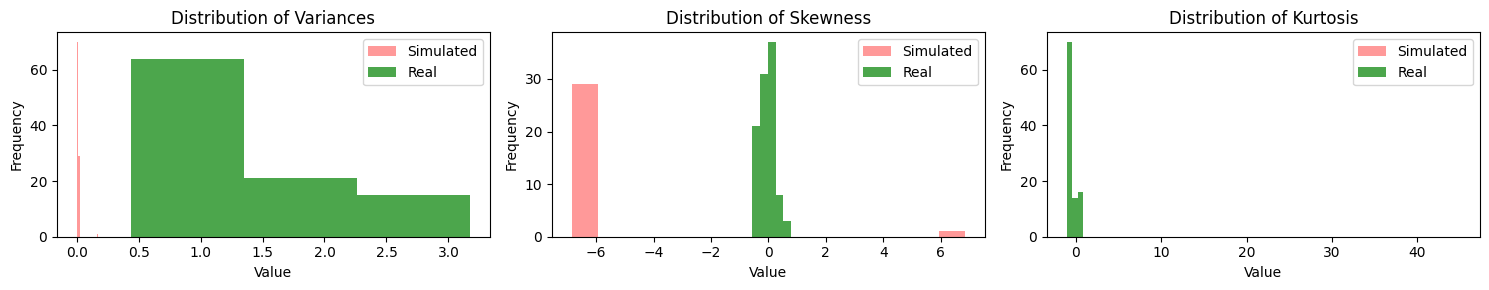

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(15, 3))

# Plot 1: Variance Distribution
axs[0].hist(sim_variances, bins=15, alpha=0.4, label='Simulated', color='red')
axs[0].hist(real_variances, bins=3, alpha=0.7, label='Real', color='green')
axs[0].legend(loc='upper right')
axs[0].set_title('Distribution of Variances')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')

# Plot 2: Skewness Distribution
axs[1].hist(sim_skew, bins=15, alpha=0.4, label='Simulated', color='red')
axs[1].hist(real_skew, bins=5, alpha=0.7, label='Real', color='green')
axs[1].legend(loc='upper right')
axs[1].set_title('Distribution of Skewness')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')

# Plot 3: Kurtosis Distribution
axs[2].hist(sim_kurtosis, bins=15, alpha=0.4, label='Simulated', color='red')
axs[2].hist(real_kurtosis, bins=3, alpha=0.7, label='Real', color='green')
axs[2].legend(loc='upper right')
axs[2].set_title('Distribution of Kurtosis')
axs[2].set_xlabel('Value')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Autocorrelation

$ACF(k) = Corr(x_t, x_{t-k})$

In [20]:
# Function to calculate ACF for each trajectory
def calculate_acf(trajectories, nlags=49):
    acfs = []
    for traj in trajectories:
        acf_values = acf(traj, fft=False, nlags=nlags)
        acfs.append(acf_values)
    return np.array(acfs)

# Function to calculate PACF for each trajectory
def calculate_pacf(trajectories, nlags=24):
    pacfs = []
    for traj in trajectories:
        pacf_values = pacf(traj, nlags=nlags)
        pacfs.append(pacf_values)
    return np.array(pacfs)

# ACFs for real and simulated trajectories
real_acfs = calculate_acf(test_data)
simulated_acfs = calculate_acf(test_fake_data)
# Average the ACFs across all trajectories
avg_real_acf = np.mean(real_acfs, axis=0)
avg_simulated_acf = np.mean(simulated_acfs, axis=0)

# Calculate PACFs for real and simulated trajectories
real_pacfs = calculate_pacf(test_data)
simulated_pacfs = calculate_pacf(test_fake_data)
# Average the PACFs across all trajectories
avg_real_pacf = np.mean(real_pacfs, axis=0)
avg_simulated_pacf = np.mean(simulated_pacfs, axis=0)

/Users/fzejnu/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/stattools.py:693: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
/Users/fzejnu/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/linear_model.py:1490: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is singular. Using pinv.", ValueWarning)
/Users/fzejnu/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/linear_model.py:1490: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is singular. Using pinv.", ValueWarning)
/Users/fzejnu/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/linear_model.py:1490: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is singular. Using pinv.", ValueWarning)
/Users/fzejnu/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/linear_model.py:1490: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is sing

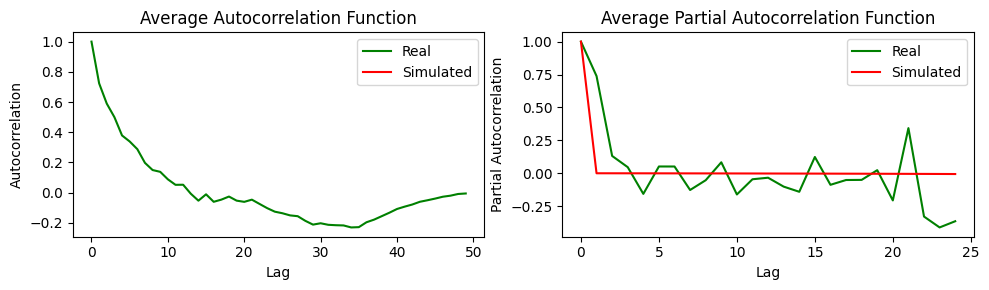

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

# Plot the averaged ACFs
axs[0].plot(avg_real_acf, label='Real', color='green')
axs[0].plot(avg_simulated_acf, label='Simulated', color='red')
axs[0].set_title('Average Autocorrelation Function')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('Autocorrelation')
axs[0].legend()

# Plot the averaged PACFs
axs[1].plot(avg_real_pacf, label='Real', color='green')
axs[1].plot(avg_simulated_pacf, label='Simulated', color='red')
axs[1].set_title('Average Partial Autocorrelation Function')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('Partial Autocorrelation')
axs[1].legend()

plt.tight_layout()
plt.show()


### GAN Framework

Generator & Discriminator Setup

In [22]:
## Change architecture when moving to refining your model
##

# Same as in self-supervised setting
class LSTMGenerator(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMGenerator, self).__init__()
        # Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM Layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        # Fully Connected Layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, hidden=None):
        embedded = self.embedding(x)
        lstm_out, (h_n, c_n) = self.lstm(embedded, hidden)
        logits = self.fc(lstm_out)
        return logits, hidden

## Simple Discriminator LSTM Network with binary classification
class LSTMDiscriminator(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):              # Output size is one
        super(LSTMDiscriminator, self).__init__()
        # Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM Layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        # Fully Connected Layer
        self.fc = nn.Linear(hidden_dim, 1)  # Output single probability
        # Sigmoid Activation for binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, hidden=None):
        # Input x shape: torch.Size([10, 49])
        embedded = self.embedding(x)
        # Output Embedding shape: torch.Size([10, 49, 32])
        lstm_out, hidden = self.lstm(embedded, hidden)
        # Output LSTM out shape: torch.Size([10, 49, 64])
        logits = self.fc(lstm_out)
        # Output Logits shape: torch.Size([10, 49, 1])
        prob = self.sigmoid(logits)
        # Output shape Prob: torch.Size([10, 49, 1])
        prob = prob.squeeze(-1)
        # Output shape Prob Squeezed: torch.Size([10, 49])
        return prob, hidden

$\beta_1:$  Controls the decay rate for the moving average of past gradients. The default value is usually 0.9, but in GANs, it's often set to 0.5. Setting $\beta_1$ to 0.5 can help stabilize GAN training, as it reduces the momentum effect, preventing the optimizer from overshooting or oscillating too much.


$\beta_2:$ Controls the decay rate for the moving average of the squared gradients. It affects how the optimizer adjusts the learning rate based on the variance of the past gradients.

In [23]:
def create_fake_sequences_old(generator, real_sequence, training=False):
    
    ## CREATE FAKE SEQUENCE
    init_real_token = real_sequence[0]
    fake_sequence = [init_real_token]

    ## PLEASE ADJUST WHEN HAVING MULTIPLE LSTM LAYERS
    h_n = torch.zeros(1, 1, 64)
    c_n = torch.zeros(1, 1, 64)
    ##
    
    generator.train() if training else generator.eval()
    
    # If testing, then no gradient calculations
    with torch.no_grad() if not training else contextlib.nullcontext():
        for _ in range(1, len(real_sequence)):
            sequence_input = torch.tensor([fake_sequence[-1]]).unsqueeze(0)
            logits, (h_n, c_n) = generator(sequence_input, (h_n, c_n))
            probs = torch.softmax(logits, dim=-1).squeeze()
            predicted_token = torch.multinomial(probs, num_samples=1).item()
            fake_sequence.append(predicted_token)
    fake_sequence = torch.tensor(fake_sequence[1:]).unsqueeze(0)
    
    return fake_sequence


GAN TRAINING

In [25]:
# Instantiate Generator and load the weights
generator = LSTMGenerator(vocab_size=num_bins, embedding_dim=32, hidden_dim=64, output_dim=num_bins)
generator.load_state_dict(torch.load('model_weights.pth'))

# Instantiate Discriminator
discriminator = LSTMDiscriminator(vocab_size=num_bins, embedding_dim=32, hidden_dim=64)

# Loss function
criterion = nn.BCELoss()
# Optimizers
D_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

num_epochs = 1000

phi_real_avg_prob = []
phi_fake_avg_prob = []

D_losses = []
G_losses = []

real_seq_during_train = []
fake_seq_during_phi_train = []
fake_seq_during_pi_train = []

for epoch in range(num_epochs):

    # Sample 10 real sequences from the train data
    start_train_idx = np.random.choice(range(len(train_data_temp)-seq_len), size=train_n_seq, replace=True)
    train_data = prep_data(seq_len=seq_len, start_indexes=start_train_idx, data=train_data_temp)
    batch_size = len(train_data)
    
    real_sequences = [torch.tensor(sequence[1:]).unsqueeze(0) for sequence in train_data]
    real_sequences = torch.cat(real_sequences[:batch_size], dim=0)  # Create a batch of real sequences
    
    # Save one sequence per epoch
    real_seq_during_train.append(real_sequences.detach()[0])

    ## ===================
    ## TRAIN DISCRIMINATOR
    ## ===================
    
    # Create Fake sequences in Test mode
    fake_sequences = [create_fake_sequences_old(generator, sequence, training=False) for sequence in train_data]
    fake_sequences = torch.cat(fake_sequences[:batch_size], dim=0)  # Create a batch of fake sequences
    
    fake_seq_during_phi_train.append(fake_sequences.detach()[0])

    # Zero the gradients
    D_optimizer.zero_grad()

    # 1. Train on real sequences (compare to 1, since 1 = real sequence)
    D_real, _ = discriminator(real_sequences)

    final_prob_real = D_real[:,-1]


    D_loss_real = criterion(final_prob_real, torch.ones_like(final_prob_real))

    # 2. Train on fake sequence (compare to 0, since 0 = fake sequence)
    D_fake, _ = discriminator(fake_sequences)
    final_prob_fake = D_fake[:, -1]
    D_loss_fake = criterion(final_prob_fake, torch.zeros_like(final_prob_fake))
    
    # Append avearge probabilites by the Discriminator
    phi_real_avg_prob.append(final_prob_real.detach().mean())
    phi_fake_avg_prob.append(final_prob_fake.detach().mean())

    # Discriminator's Loss and Optimization
    D_loss = (D_loss_real + D_loss_fake) / 2    
    D_loss.backward()
    D_optimizer.step()
    D_losses.append(D_loss.item())

    ## ===============
    ## TRAIN GENERATOR
    ## ===============

    # Zero the gradients
    G_optimizer.zero_grad()

    # Create Fake sequences in Test mode
    fake_sequences = [create_fake_sequences_old(generator, sequence, training=True) for sequence in train_data]
    fake_sequences = torch.cat(fake_sequences[:batch_size], dim=0)  # Create a batch of fake sequences

    fake_seq_during_pi_train.append(fake_sequences.detach()[0])
    
    # Receive the reward
    D_fake, _ = discriminator(fake_sequences)
    final_prob_fake = D_fake[:, -1]

    # Generator's Loss and Optimization
    G_loss = criterion(final_prob_fake, torch.ones_like(final_prob_fake))
    #### G_loss.backward()
    #### G_optimizer.step()
    G_losses.append(G_loss.item())


D_real torch.Size([10, 49])
D_real tensor([[0.4700, 0.4648, 0.4613, 0.4545, 0.4520, 0.4500, 0.4483, 0.4368, 0.4341,
         0.4399, 0.4426, 0.4453, 0.4355, 0.4412, 0.4441, 0.4466, 0.4355, 0.4415,
         0.4341, 0.4401, 0.4433, 0.4347, 0.4406, 0.4437, 0.4462, 0.4481, 0.4494,
         0.4363, 0.4424, 0.4451, 0.4351, 0.4327, 0.4390, 0.4340, 0.4331, 0.4278,
         0.4283, 0.4297, 0.4308, 0.4314, 0.4317, 0.4319, 0.4320, 0.4320, 0.4320,
         0.4320, 0.4321, 0.4321, 0.4517],
        [0.4678, 0.4650, 0.4699, 0.4692, 0.4671, 0.4650, 0.4633, 0.4544, 0.4630,
         0.4559, 0.4583, 0.4604, 0.4618, 0.4625, 0.4895, 0.5011, 0.5064, 0.4771,
         0.4689, 0.4928, 0.4720, 0.4671, 0.4918, 0.4718, 0.4670, 0.4651, 0.4643,
         0.4639, 0.4637, 0.4636, 0.4635, 0.4634, 0.4898, 0.5015, 0.5068, 0.5090,
         0.5098, 0.5100, 0.5099, 0.5098, 0.5097, 0.5096, 0.5095, 0.5095, 0.5094,
         0.4790, 0.4696, 0.4660, 0.4910],
        [0.4579, 0.4631, 0.4669, 0.4692, 0.4705, 0.4713, 0.4718, 0.459

/var/folders/1x/hjv8bl714_xgsbdy8fp5kj140000gn/T/ipykernel_58496/2952411296.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('model_w

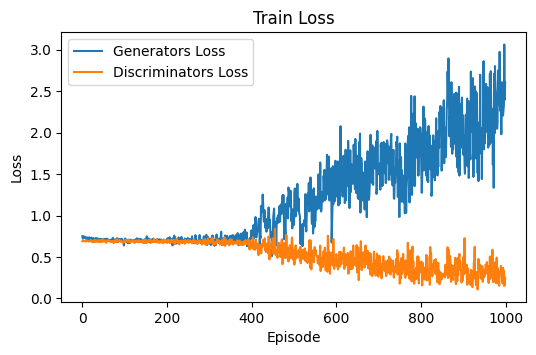

In [26]:
plt.figure(figsize=(6, 3.5))
plt.plot(G_losses, label='Generators Loss')
plt.plot(D_losses, label='Discriminators Loss')
plt.title("Train Loss")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.legend()
plt.show()

Text(0, 0.5, 'Probability')

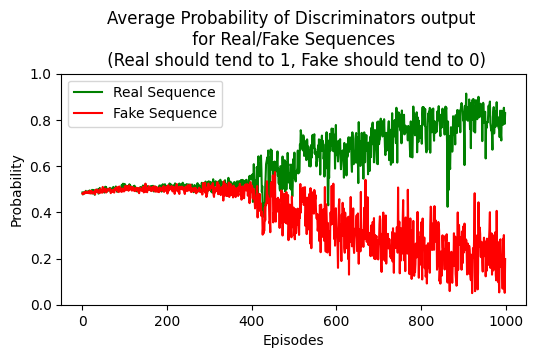

In [27]:
plt.figure(figsize=(6,3))
plt.plot(phi_real_avg_prob, color='green', label='Real Sequence')
plt.plot(phi_fake_avg_prob, color='red', label='Fake Sequence')
plt.ylim(0,1)
plt.title('Average Probability of Discriminators output \n for Real/Fake Sequences \n (Real should tend to 1, Fake should tend to 0)', size = 12)
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Probability')

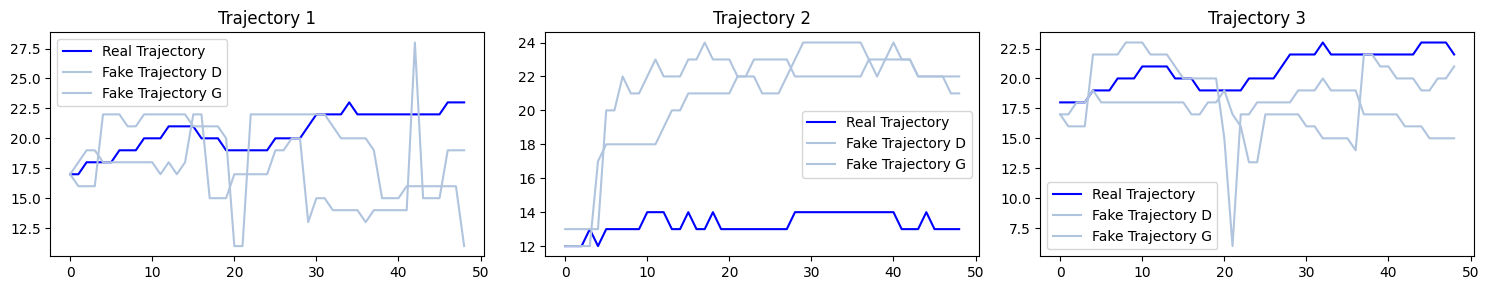

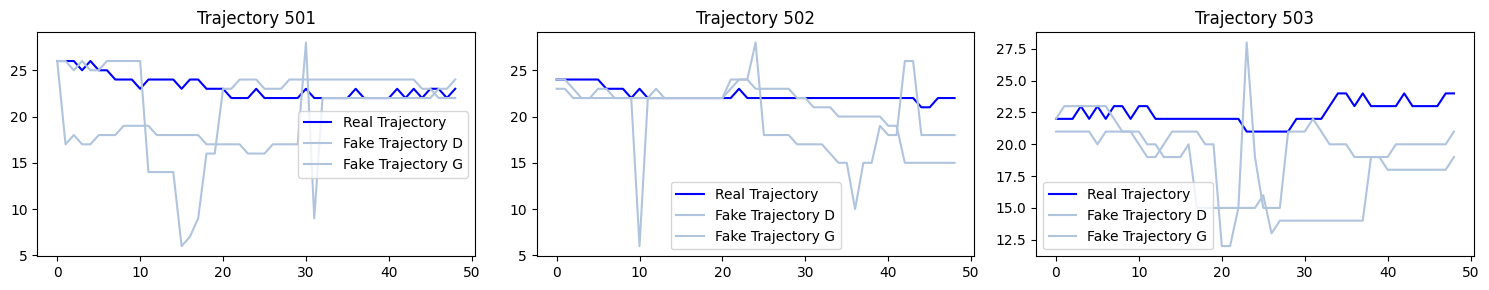

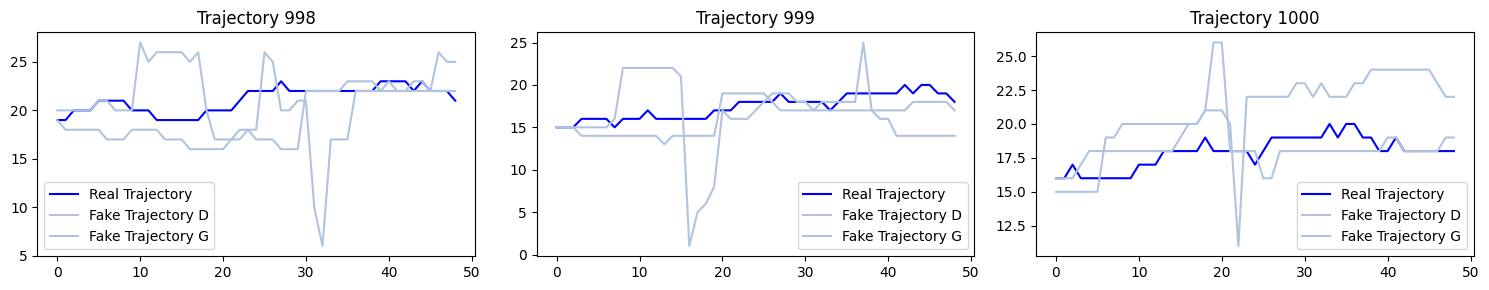

In [28]:
middle_seq = int(len(real_seq_during_train)/2)
end_seq = int(len(real_seq_during_train))

fig, axes = plt.subplots(1, 3, figsize=(15, 3))  # 3 rows, 3 columns, and adjust the size
axes = axes.flatten()
for i in range(3):
    axes[i].plot(real_seq_during_train[i], label='Real Trajectory', color = 'blue')
    axes[i].plot(fake_seq_during_phi_train[i], label='Fake Trajectory D', color = 'lightsteelblue')
    axes[i].plot(fake_seq_during_pi_train[i], label='Fake Trajectory G', color = 'lightsteelblue')
    axes[i].legend()
    axes[i].set_title(f'Trajectory {i+1}')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 3))  # 3 rows, 3 columns, and adjust the size
axes = axes.flatten()
for i in range(3):
    axes[i].plot(real_seq_during_train[middle_seq + i], label='Real Trajectory', color = 'blue')
    axes[i].plot(fake_seq_during_phi_train[middle_seq + i], label='Fake Trajectory D', color = 'lightsteelblue')
    axes[i].plot(fake_seq_during_pi_train[middle_seq + i], label='Fake Trajectory G', color = 'lightsteelblue')
    axes[i].legend()
    axes[i].set_title(f'Trajectory {middle_seq+i+1}')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 3))  # 3 rows, 3 columns, and adjust the size
axes = axes.flatten()
for i in range(3):
    axes[i].plot(real_seq_during_train[end_seq - 3  + i], label='Real Trajectory', color = 'blue')
    axes[i].plot(fake_seq_during_phi_train[end_seq - 3 + i], label='Fake Trajectory D', color = 'lightsteelblue')
    axes[i].plot(fake_seq_during_pi_train[end_seq - 3 + i], label='Fake Trajectory G', color = 'lightsteelblue')
    axes[i].legend()
    axes[i].set_title(f'Trajectory {end_seq - 3 +i+1}')
plt.tight_layout()
plt.show()

#### Training the GENERATOR
We create a fake sequence from the **Generator** which serves as an input for the **Discriminator**. The **Discriminator** then outputs the probabilty of being a real sequence (1 = real, 0 = fake). This probabilty is used within the the **Generator** training as a *loss* $BCE(p_{discr}, 1), p_{discr} \in (0,1)$ and compared to 1 since we want to encourage the **Generator** creating realistic sequences which the **Discriminator** would label as real. 

$\text{BCE Loss} = - \left[ y \cdot \log(p) + (1 - y) \cdot \log(1 - p) \right]$

Training did not work well since the generator is **NOT TRAINING** at all. The issue: When creating a fake sequence from the **Generator** we sample the next "Token" based on the probability given by the **LSTM** network. Since we sample the Token, we will lose it's connection to the computational graph of the **LSTM** Networks. Therefore when calculating the gradient with **.backward()** and optimizing **optimizer.step()**, the process won't have any computational graph to compute the gradients and update the weigths.

We will now introduce the **Reinforcement learning approach**, which should resolve our issue. We treat the Generator as a **Policy Network** where the states are the input token and the output is a probablity distribution over **actions** (tokens). For each action/token in the sequence, the log probability of the chosen token/action is calculated. For the whole sequence, we sum all the actions (log probabilites) and multiply the **Reward** which is the output of the Discriminator (probablity of the fake sequence being true). The overall loss is the negative of this sum, as we want to increase the likelihood of actions (tokens) that lead to higher rewards.

$\text{Policy Loss} = - \sum_{t=1}^{T} \log\pi_\theta(a_t | s_t) \cdot R$





In [29]:
def create_fake_sequences(generator, real_sequence, training=False):
    
    init_real_token = real_sequence[0]
    fake_sequence = [init_real_token]
    log_probs = []

    ## PLEASE ADJUST WHEN HAVING MULTIPLE LSTM LAYERS
    h_n = torch.zeros(1, 1, 64)
    c_n = torch.zeros(1, 1, 64)
    ##
    
    generator.train() if training else generator.eval()
    
    # If testing, then no gradient calculations
    with torch.no_grad() if not training else contextlib.nullcontext():

        for _ in range(1, len(real_sequence)):

            sequence_input = torch.tensor([fake_sequence[-1]]).unsqueeze(0)
            logits, (h_n, c_n) = generator(sequence_input, (h_n, c_n))
            probs = torch.softmax(logits, dim=-1).squeeze()
            # Predicted Token
            action = torch.multinomial(probs, num_samples=1)
            # Log probability or the Policy Loss
            log_prob = torch.log(probs[action])
            log_probs.append(log_prob)
            fake_sequence.append(action.item())

    fake_sequence = torch.tensor(fake_sequence[1:]).unsqueeze(0)
    log_probs = torch.cat(log_probs).squeeze(0)
    
    return fake_sequence, log_probs

In [30]:
# Instantiate Generator and load the weights
generator = LSTMGenerator(vocab_size=num_bins, embedding_dim=32, hidden_dim=64, output_dim=num_bins)
generator.load_state_dict(torch.load('model_weights.pth', weights_only=False))

# Instantiate Discriminator
discriminator = LSTMDiscriminator(vocab_size=num_bins, embedding_dim=32, hidden_dim=64)

# Loss function
criterion = nn.BCELoss()
# Optimizers
D_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

num_epochs = 1000

phi_real_avg_prob = []
phi_fake_avg_prob = []

D_losses = []
G_losses = []

real_seq_during_train = []
fake_seq_during_phi_train = []
fake_seq_during_pi_train = []

D_val_loss = []
G_val_loss = []

for epoch in range(num_epochs):

    # Sample 10 real sequences from the train data
    start_train_idx = np.random.choice(range(len(train_data_temp) - seq_len), size=train_n_seq, replace=True)
    train_data = prep_data(seq_len=seq_len, start_indexes=start_train_idx, data=train_data_temp)
    batch_size = len(train_data)
    
    real_sequences = [torch.tensor(sequence[1:]).unsqueeze(0) for sequence in train_data]
    real_sequences = torch.cat(real_sequences[:batch_size], dim=0)  # Create a batch of real sequences
    
    # Save one sequence per epoch
    real_seq_during_train.append(real_sequences.detach()[0])

    ## ===================
    ## TRAIN DISCRIMINATOR
    ## ===================

    # Create Fake sequences in Test mode
    fake_sequences = []
    for sequence in train_data:
        fake_sequence, _ = create_fake_sequences(generator, sequence, training=False)
        fake_sequences.append(fake_sequence)
    fake_sequences = torch.cat(fake_sequences[:batch_size], dim=0)  # Create a batch of fake sequences
    
    fake_seq_during_phi_train.append(fake_sequences.detach()[0])

    # Zero the gradients
    D_optimizer.zero_grad()

    # 1. Train on real sequences (compare to 1, since 1 = real sequence)
    D_real, _ = discriminator(real_sequences)
    final_prob_real = D_real[:, -1]
    D_loss_real = criterion(final_prob_real, torch.ones_like(final_prob_real))

    # 2. Train on fake sequence (compare to 0, since 0 = fake sequence)
    D_fake, _ = discriminator(fake_sequences)
    final_prob_fake = D_fake[:, -1]
    D_loss_fake = criterion(final_prob_fake, torch.zeros_like(final_prob_fake))
    
    # Append avearge probabilites by the Discriminator
    phi_real_avg_prob.append(final_prob_real.detach().mean())
    phi_fake_avg_prob.append(final_prob_fake.detach().mean())

    # Discriminator's Loss and Optimization
    D_loss = (D_loss_real + D_loss_fake) / 2    
    D_loss.backward()
    D_optimizer.step()
    D_losses.append(D_loss.item())

    ## ===============
    ## TRAIN GENERATOR
    ## ===============

    # Zero the gradients
    G_optimizer.zero_grad()

    # Create Fake sequences in Test mode
    fake_sequences = []
    log_probs_batch = []
    for sequence in train_data:
        fake_sequence, log_probs = create_fake_sequences(generator, sequence, training=True)
        fake_sequences.append(fake_sequence)
        # Sum log probabilities for the sequence
        log_probs_batch.append(log_probs.sum())

    fake_sequences = torch.cat(fake_sequences[:batch_size], dim=0)
    fake_seq_during_pi_train.append(fake_sequences.detach()[0])
    
    # Stack the log_probs of the entire batch
    log_probs_batch = torch.stack(log_probs_batch)

    # Receive Reward from the Discriminator
    D_fake, _ = discriminator(fake_sequences)
    rewards = D_fake[:, -1].detach()

    # Calucalte the Policy Loss
    policy_loss = - (log_probs_batch * rewards)
    policy_loss = policy_loss.mean()
    
    # Generator's Loss and Optimization
    policy_loss.backward()
    G_optimizer.step()
    G_losses.append(policy_loss.item())

    #print(f'Epoch [{epoch+1}/{num_epochs}] | D Loss: {D_loss.item():.4f} | G Loss: {policy_loss.item():.4f}')

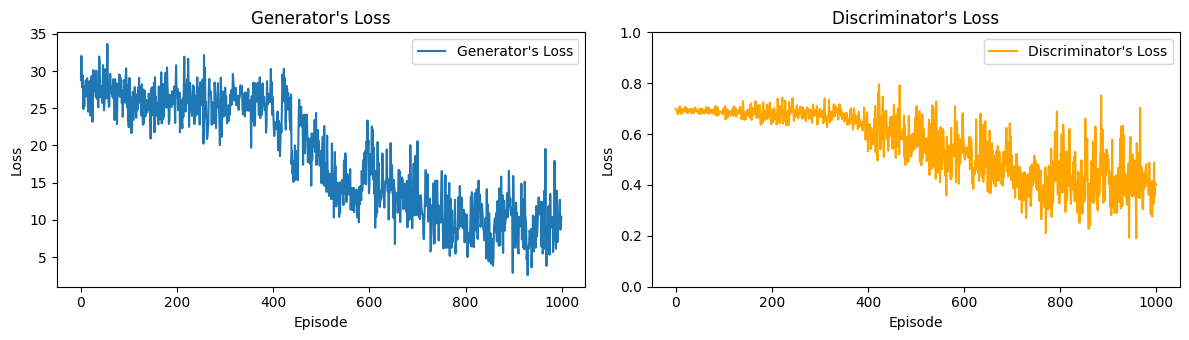

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3.5))

# Generator's Loss in the first subplot
axs[0].plot(G_losses, label="Generator's Loss")
axs[0].set_title("Generator's Loss")
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Loss")
axs[0].legend()
# Discriminator's Loss
axs[1].plot(D_losses, color='orange', label="Discriminator's Loss")
axs[1].set_title("Discriminator's Loss")
axs[1].set_ylim(0,1)
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.tight_layout()
plt.show()


Text(0, 0.5, 'Probability')

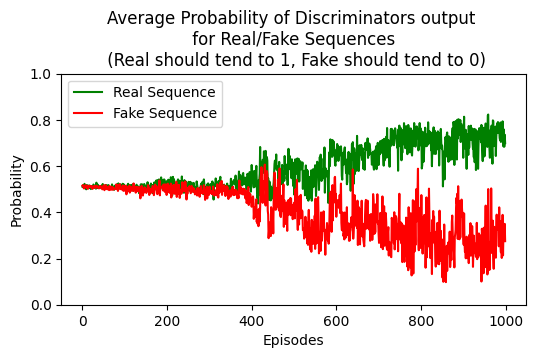

In [35]:
plt.figure(figsize=(6,3))
plt.plot(phi_real_avg_prob, color='green', label='Real Sequence')
plt.plot(phi_fake_avg_prob, color='red', label='Fake Sequence')
plt.ylim(0,1)
plt.title('Average Probability of Discriminators output \n for Real/Fake Sequences \n (Real should tend to 1, Fake should tend to 0)', size = 12)
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Probability')

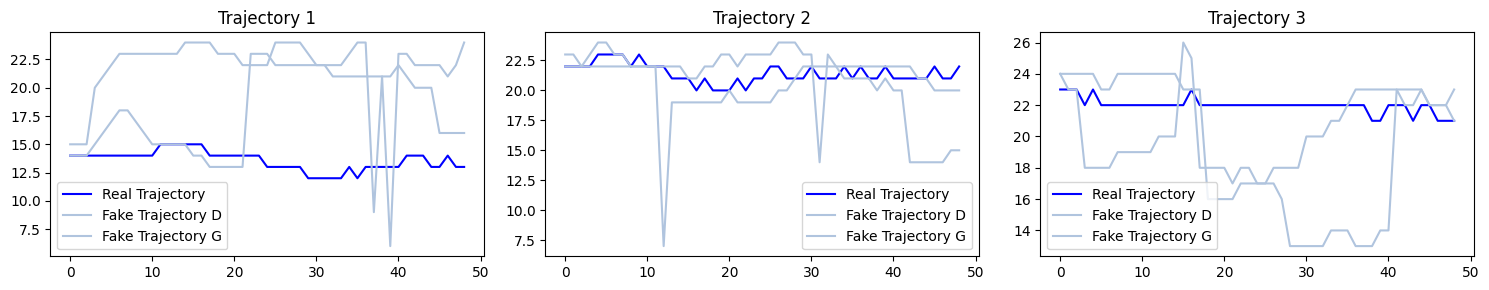

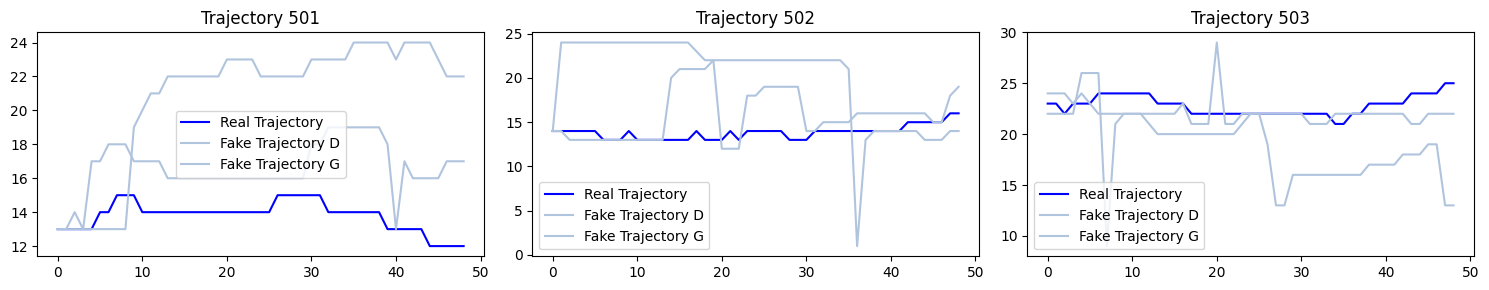

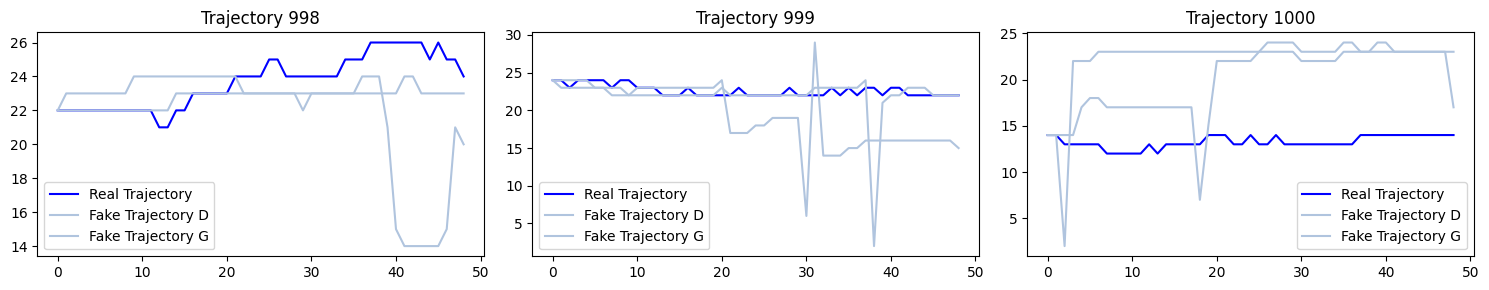

In [36]:
middle_seq = int(len(real_seq_during_train)/2)
end_seq = int(len(real_seq_during_train))

fig, axes = plt.subplots(1, 3, figsize=(15, 3))  # 3 rows, 3 columns, and adjust the size
axes = axes.flatten()
for i in range(3):
    axes[i].plot(real_seq_during_train[i], label='Real Trajectory', color = 'blue')
    axes[i].plot(fake_seq_during_phi_train[i], label='Fake Trajectory D', color = 'lightsteelblue')
    axes[i].plot(fake_seq_during_pi_train[i], label='Fake Trajectory G', color = 'lightsteelblue')
    axes[i].legend()
    axes[i].set_title(f'Trajectory {i+1}')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 3))  # 3 rows, 3 columns, and adjust the size
axes = axes.flatten()
for i in range(3):
    axes[i].plot(real_seq_during_train[middle_seq + i], label='Real Trajectory', color = 'blue')
    axes[i].plot(fake_seq_during_phi_train[middle_seq + i], label='Fake Trajectory D', color = 'lightsteelblue')
    axes[i].plot(fake_seq_during_pi_train[middle_seq + i], label='Fake Trajectory G', color = 'lightsteelblue')
    axes[i].legend()
    axes[i].set_title(f'Trajectory {middle_seq+i+1}')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 3))  # 3 rows, 3 columns, and adjust the size
axes = axes.flatten()
for i in range(3):
    axes[i].plot(real_seq_during_train[end_seq - 3  + i], label='Real Trajectory', color = 'blue')
    axes[i].plot(fake_seq_during_phi_train[end_seq - 3 + i], label='Fake Trajectory D', color = 'lightsteelblue')
    axes[i].plot(fake_seq_during_pi_train[end_seq - 3 + i], label='Fake Trajectory G', color = 'lightsteelblue')
    axes[i].legend()
    axes[i].set_title(f'Trajectory {end_seq - 3 +i+1}')
plt.tight_layout()
plt.show()

In [160]:
def check_gradients(model):
    grads = []
    for name, param in model.named_parameters():
        # Print the first 5 weights for each parameter
        print(f"{name} - First 5 weights: {param.data.view(-1)[:5]}")
        
        if param.grad is not None:
            grads.append(param.grad.abs().sum().item())
        else:
            grads.append(None)
    
    return grads

In [164]:
# Instantiate Generator and load the weights
generator = LSTMGenerator(vocab_size=num_bins, embedding_dim=32, hidden_dim=64, output_dim=num_bins)
generator.load_state_dict(torch.load('model_weights.pth', weights_only=False))

# Instantiate Discriminator
discriminator = LSTMDiscriminator(vocab_size=num_bins, embedding_dim=32, hidden_dim=64)

# Loss function
criterion = nn.BCELoss()
# Optimizers
D_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

num_epochs = 1000

phi_real_avg_prob = []
phi_fake_avg_prob = []

D_losses = []
G_losses = []

real_seq_during_train = []
fake_seq_during_phi_train = []
fake_seq_during_pi_train = []

for epoch in range(num_epochs):

    # Sample 10 real sequences from the train data
    start_train_idx = np.random.choice(range(len(train_data_temp) - seq_len), size=train_n_seq, replace=True)
    train_data = prep_data(seq_len=seq_len, start_indexes=start_train_idx, data=train_data_temp)
    batch_size = len(train_data)
    
    real_sequences = [torch.tensor(sequence[1:]).unsqueeze(0) for sequence in train_data]
    real_sequences = torch.cat(real_sequences[:batch_size], dim=0)  # Create a batch of real sequences
    
    # Save one sequence per epoch
    real_seq_during_train.append(real_sequences.detach()[0])

    ## ===================
    ## TRAIN DISCRIMINATOR
    ## ===================

    # Create Fake sequences in Test mode
    fake_sequences = []
    for sequence in train_data:
        fake_sequence, _ = create_fake_sequences(generator, sequence, training=False)
        fake_sequences.append(fake_sequence)
    fake_sequences = torch.cat(fake_sequences[:batch_size], dim=0)  # Create a batch of fake sequences
    
    fake_seq_during_phi_train.append(fake_sequences.detach()[0])

    # Zero the gradients
    D_optimizer.zero_grad()

    # 1. Train on real sequences (compare to 1, since 1 = real sequence)
    D_real, _ = discriminator(real_sequences)
    final_prob_real = D_real[:, -1]
    D_loss_real = criterion(final_prob_real, torch.ones_like(final_prob_real))

    # 2. Train on fake sequence (compare to 0, since 0 = fake sequence)
    D_fake, _ = discriminator(fake_sequences)
    final_prob_fake = D_fake[:, -1]
    D_loss_fake = criterion(final_prob_fake, torch.zeros_like(final_prob_fake))
    
    # Append avearge probabilites by the Discriminator
    phi_real_avg_prob.append(final_prob_real.detach().mean())
    phi_fake_avg_prob.append(final_prob_fake.detach().mean())


    print('DISCRIMINATOR TRAINING')
    print('')
    print("DISCRIMINATOR Gradients before backpropagation (should be None):")
    print(check_gradients(discriminator))

    print('')
    print("GENERATOR Gradients within discriminator training (should be None):")
    print(check_gradients(generator))

    # Discriminator's Loss and Optimization
    D_loss = (D_loss_real + D_loss_fake) / 2    
    D_loss.backward()
    D_optimizer.step()
    D_losses.append(D_loss.item())

    print('')
    print("DISCRIMINATOR after backpropagation (should be NOT None):")
    print(check_gradients(discriminator))

    print('')
    print("GENERATOR Gradients within discriminator training (should be None):")
    print(check_gradients(generator))

    ## ===============
    ## TRAIN GENERATOR
    ## ===============

    # Zero the gradients
    G_optimizer.zero_grad()

    # Create Fake sequences in Test mode
    fake_sequences = []
    log_probs_batch = []
    for sequence in train_data:
        fake_sequence, log_probs = create_fake_sequences(generator, sequence, training=True)
        fake_sequences.append(fake_sequence)
        # Sum log probabilities for the sequence
        log_probs_batch.append(log_probs.sum())

    fake_sequences = torch.cat(fake_sequences[:batch_size], dim=0)
    fake_seq_during_pi_train.append(fake_sequences.detach()[0])
    
    # Stack the log_probs of the entire batch
    log_probs_batch = torch.stack(log_probs_batch)
    
    # Receive Reward from the Discriminator
    D_fake, _ = discriminator(fake_sequences)
    rewards = D_fake[:, -1].detach()

    # Calucalte the Policy Loss
    policy_loss = - (log_probs_batch * rewards)
    policy_loss = policy_loss.mean()

    print('')
    print('')

    print('GENERATOR TRAINING')

    print('')
    print("GENERATOR before backpropagation (should be None):")
    print(check_gradients(generator))

    print('')
    print("DISCRIMINATOR Gradients within generator training (prior) (should stay the same):")
    print(check_gradients(discriminator))
    
    # Generator's Loss and Optimization
    policy_loss.backward()
    G_optimizer.step()
    G_losses.append(policy_loss.item())

    print('')
    print("GENERATOR after backpropagation (should be NOT None):")
    print(check_gradients(generator))

    print('')
    print("DISCRIMINATOR Gradients within generator training (should stay the same):")
    print(check_gradients(discriminator))


    break

    #print(f'Epoch [{epoch+1}/{num_epochs}] | D Loss: {D_loss.item():.4f} | G Loss: {policy_loss.item():.4f}')

DISCRIMINATOR TRAINING

DISCRIMINATOR Gradients before backpropagation (should be None):
embedding.weight - First 5 weights: tensor([-1.0924,  1.2170, -1.4851, -0.3217, -1.7958])
lstm.weight_ih_l0 - First 5 weights: tensor([ 0.0448, -0.0333,  0.0601, -0.0336,  0.0797])
lstm.weight_hh_l0 - First 5 weights: tensor([ 0.0338,  0.0410, -0.0628,  0.0859, -0.0925])
lstm.bias_ih_l0 - First 5 weights: tensor([ 0.0218, -0.0206, -0.0861, -0.0554, -0.0619])
lstm.bias_hh_l0 - First 5 weights: tensor([ 0.1035, -0.1234, -0.0151,  0.0602,  0.0853])
fc.weight - First 5 weights: tensor([-0.0479,  0.1188,  0.0527,  0.1174,  0.1079])
fc.bias - First 5 weights: tensor([-0.0044])
[None, None, None, None, None, None, None]

GENERATOR Gradients within discriminator training (should be None):
embedding.weight - First 5 weights: tensor([ 1.7816, -0.0954,  2.0137, -0.3664, -2.1872])
lstm.weight_ih_l0 - First 5 weights: tensor([-0.1041,  0.1400,  0.2199, -0.0798,  0.0279])
lstm.weight_hh_l0 - First 5 weights: ten

In [156]:
def create_fake_sequences_old(generator, real_sequence, training=False):
    
    init_real_token = real_sequence[0]
    fake_sequence = [init_real_token]
    log_probs = []

    ## PLEASE ADJUST WHEN HAVING MULTIPLE LSTM LAYERS
    h_n = torch.zeros(1, 1, 64)
    c_n = torch.zeros(1, 1, 64)
    ##
    
    generator.train() if training else generator.eval()
    
    # If testing, then no gradient calculations
    with torch.no_grad() if not training else contextlib.nullcontext():

        for _ in range(1, len(real_sequence)):

            sequence_input = torch.tensor([fake_sequence[-1]]).unsqueeze(0)
            logits, (h_n, c_n) = generator(sequence_input, (h_n, c_n))
            probs = torch.softmax(logits, dim=-1).squeeze()
            # Predicted Token
            action = torch.multinomial(probs, num_samples=1)
            # Log probability or the Policy Loss
            log_prob = torch.log(probs[action])
            log_probs.append(log_prob)
            fake_sequence.append(action.item())

    fake_sequence = torch.tensor(fake_sequence[1:]).unsqueeze(0)
    log_probs = torch.cat(log_probs).squeeze(0)
    
    return fake_sequence

In [157]:
# Instantiate Generator and load the weights
generator = LSTMGenerator(vocab_size=num_bins, embedding_dim=32, hidden_dim=64, output_dim=num_bins)
generator.load_state_dict(torch.load('model_weights.pth', weights_only=False))

# Instantiate Discriminator
discriminator = LSTMDiscriminator(vocab_size=num_bins, embedding_dim=32, hidden_dim=64)

# Loss function
criterion = nn.BCELoss()
# Optimizers
D_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

num_epochs = 1000

phi_real_avg_prob = []
phi_fake_avg_prob = []

D_losses = []
G_losses = []

real_seq_during_train = []
fake_seq_during_phi_train = []
fake_seq_during_pi_train = []

for epoch in range(num_epochs):

    # Sample 10 real sequences from the train data
    start_train_idx = np.random.choice(range(len(train_data_temp)-seq_len), size=train_n_seq, replace=True)
    train_data = prep_data(seq_len=seq_len, start_indexes=start_train_idx, data=train_data_temp)
    batch_size = len(train_data)
    
    real_sequences = [torch.tensor(sequence[1:]).unsqueeze(0) for sequence in train_data]
    real_sequences = torch.cat(real_sequences[:batch_size], dim=0)  # Create a batch of real sequences
    
    # Save one sequence per epoch
    real_seq_during_train.append(real_sequences.detach()[0])

    ## ===================
    ## TRAIN DISCRIMINATOR
    ## ===================
    
    # Create Fake sequences in Test mode
    fake_sequences = [create_fake_sequences_old(generator, sequence, training=False) for sequence in train_data]
    fake_sequences = torch.cat(fake_sequences[:batch_size], dim=0)  # Create a batch of fake sequences
    
    fake_seq_during_phi_train.append(fake_sequences.detach()[0])

    # Zero the gradients
    D_optimizer.zero_grad()

    # 1. Train on real sequences (compare to 1, since 1 = real sequence)
    D_real, _ = discriminator(real_sequences)
    final_prob_real = D_real[:,-1]
    D_loss_real = criterion(final_prob_real, torch.ones_like(final_prob_real))

    # 2. Train on fake sequence (compare to 0, since 0 = fake sequence)
    D_fake, _ = discriminator(fake_sequences)
    final_prob_fake = D_fake[:, -1]
    D_loss_fake = criterion(final_prob_fake, torch.zeros_like(final_prob_fake))
    
    # Append avearge probabilites by the Discriminator
    phi_real_avg_prob.append(final_prob_real.detach().mean())
    phi_fake_avg_prob.append(final_prob_fake.detach().mean())

    print('DISCRIMINATOR TRAINING')
    print('')
    print("DISCRIMINATOR Gradients before backpropagation (should be None):")
    print(check_gradients(discriminator))

    print('')
    print("GENERATOR Gradients within discriminator training (should be None):")
    print(check_gradients(generator))

    # Discriminator's Loss and Optimization
    D_loss = (D_loss_real + D_loss_fake) / 2    
    D_loss.backward()
    D_optimizer.step()
    D_losses.append(D_loss.item())
    
    print('')
    print("DISCRIMINATOR after backpropagation (should be NOT None):")
    print(check_gradients(discriminator))

    print('')
    print("GENERATOR Gradients within discriminator training (should be None):")
    print(check_gradients(generator))

    ## ===============
    ## TRAIN GENERATOR
    ## ===============

    # Zero the gradients
    G_optimizer.zero_grad()

    # Create Fake sequences in Test mode
    fake_sequences = [create_fake_sequences_old(generator, sequence, training=True) for sequence in train_data]
    fake_sequences = torch.cat(fake_sequences[:batch_size], dim=0)  # Create a batch of fake sequences

    fake_seq_during_pi_train.append(fake_sequences.detach()[0])
    
    # Receive the reward
    D_fake, _ = discriminator(fake_sequences)
    final_prob_fake = D_fake[:, -1]
    
    print('')
    print('')

    print('GENERATOR TRAINING')

    print('')
    print("GENERATOR before backpropagation (should be None):")
    print(check_gradients(generator))

    print('')
    print("DISCRIMINATOR Gradients within generator training (prior) (should stay the same):")
    print(check_gradients(discriminator))

    # Generator's Loss and Optimization
    G_loss = criterion(final_prob_fake, torch.ones_like(final_prob_fake))
    G_loss.backward()
    G_optimizer.step()
    G_losses.append(G_loss.item())

    print('')
    print("GENERATOR after backpropagation (should be NOT None):")
    print(check_gradients(generator))

    print('')
    print("DISCRIMINATOR Gradients within generator training (should stay the same):")
    print(check_gradients(discriminator))

    break

DISCRIMINATOR TRAINING

DISCRIMINATOR Gradients before backpropagation (should be None):
embedding.weight - First 5 weights: tensor([ 0.2777,  0.1662,  0.2462,  0.2507, -0.0435])
lstm.weight_ih_l0 - First 5 weights: tensor([ 0.0600,  0.0246, -0.0497, -0.1156, -0.0083])
lstm.weight_hh_l0 - First 5 weights: tensor([-0.0957,  0.1230,  0.0502, -0.0378, -0.0073])
lstm.bias_ih_l0 - First 5 weights: tensor([-0.0014,  0.1157,  0.0116, -0.0881, -0.0213])
lstm.bias_hh_l0 - First 5 weights: tensor([ 0.0414,  0.1168,  0.0935, -0.0812, -0.1090])
fc.weight - First 5 weights: tensor([-0.0961,  0.0367, -0.0700,  0.1136,  0.0999])
fc.bias - First 5 weights: tensor([0.0868])
[None, None, None, None, None, None, None]

GENERATOR Gradients within discriminator training (should be None):
embedding.weight - First 5 weights: tensor([ 1.7816, -0.0954,  2.0137, -0.3664, -2.1872])
lstm.weight_ih_l0 - First 5 weights: tensor([-0.1041,  0.1400,  0.2199, -0.0798,  0.0279])
lstm.weight_hh_l0 - First 5 weights: tens